# Python Implementation of Experiments for Thesis

### Import Libraries

In [1]:
#-------------------------Setting the randomness-------#
import numpy as np
np.random.seed(1)

from tensorflow import set_random_seed
set_random_seed(1)
#------------------------------------------------------#

import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle



/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Load in training and testing dataset

In [2]:
from numpy import load
train_data = load('training_data.npy')
test_data = load('testing_data.npy')

In [3]:
print(train_data[3874])
print(train_data[3875])
print(len(train_data[3875:]))


[1.         0.05098039 0.05490196 ... 0.05098039 0.04705882 0.04705882]
[0.         0.09019608 0.07058824 ... 0.44705883 0.45882353 0.44313726]
1341


In [4]:
print(test_data[389])
print(test_data[390])

[1.         0.03137255 0.04705882 ... 0.         0.         0.        ]
[0.         0.12156863 0.12156863 ... 0.1254902  0.12941177 0.13333334]


 ## Method to choose balancing of training data

In [5]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        val
        #training_data = train_data
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data


In [6]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)

(5216, 62501)
(468, 62501)


## We need to shuffle the data to allow the Model to learn in a varied manner


In [7]:
## Shuffling the data to make it more varied with yes or no to shuffling
def ShuffelData(data,option):
    if(option=="yes"):
        data = shuffle(data,random_state=0)
        return data
    else:
        return data
training_data = ShuffelData(training_data,"no")

In [8]:
X_train = training_data[0:,1:]
Y_train = training_data[0:,0:1]
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [9]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)

In [10]:
X_train = X_train.reshape(X_train.shape[0],250,250,1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,1)
print(X_test.shape)

(5216, 250, 250, 1)
(468, 250, 250, 1)


## Create 2D CNN 

## 1. Define Sequential Model
## 2. Add 2D CNN with 32 filters,3x3 filters
## 3. Apply Relu
## 4. Apply Batch Norm
## Repeat x2
## 5. Apply MaxPooling(2,2)
## 6. Send through Fully Connected Layer


In [11]:
def create_model():
    model_CNN = Sequential()
    model_CNN.add(Conv2D(32,(3,3),input_shape=(250,250,1)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization(axis=-1))
    model_CNN.add(Conv2D(32, (3, 3)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization(axis=-1))

    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Flatten())

    # Fully connected layer
    model_CNN.add(Dense(128))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization())
    #model_CNN.add(Dropout(0.2))
    model_CNN.add(Dense(2))
    model_CNN.add(Activation('softmax'))
    
    return model_CNN

# Setup for the experiment below

## 1. Model is ran with the above architeture 
## 2.Trained on Imbalanced Set
## 3. Tested on Balanced Set

# This is a test to see if running 10 experiments for the same setup of model produces the same results 

In [13]:
accuracy = []
for i in range(0,10):
    model = create_model() 
    opt = optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    model.fit(X_train, y_train_ohe,batch_size=64,epochs=25,validation_data=(X_test, y_test_ohe))# model
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(round(score[1]*100))


W0212 20:50:02.658175 140301951469376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0212 20:50:04.524966 140301951469376 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0212 20:50:05.346380 140301951469376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 5216 samples, validate on 468 samples
Epoch 1/25
5216/5216 [==============================] - 15s 3ms/step - loss: 0.2130 - accuracy: 0.9227 - val_loss: 2.0270 - val_accuracy: 0.5107
Epoch 2/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0877 - accuracy: 0.9651 - val_loss: 3.6038 - val_accuracy: 0.5000
Epoch 3/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 2.6041 - val_accuracy: 0.5000
Epoch 4/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0554 - accuracy: 0.9808 - val_loss: 1.1945 - val_accuracy: 0.6325
Epoch 5/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0393 - accuracy: 0.9850 - val_loss: 3.4786 - val_accuracy: 0.5085
Epoch 6/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0254 - accuracy: 0.9893 - val_loss: 3.6075 - val_accuracy: 0.5491
Epoch 7/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0142

5216/5216 [==============================] - 12s 2ms/step - loss: 0.0241 - accuracy: 0.9908 - val_loss: 3.5660 - val_accuracy: 0.5833
Epoch 10/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 1.3808 - val_accuracy: 0.7457
Epoch 11/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 60.3480 - val_accuracy: 0.5000
Epoch 12/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 8.9525 - val_accuracy: 0.5214
Epoch 13/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0163 - accuracy: 0.9941 - val_loss: 15.3916 - val_accuracy: 0.6432
Epoch 14/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0275 - accuracy: 0.9889 - val_loss: 15.1896 - val_accuracy: 0.5000
Epoch 15/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0238 - accuracy: 0.9898 - val_loss: 2.6500 - val_accu

Epoch 14/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 10.8315 - val_accuracy: 0.5043
Epoch 15/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 2.2765 - val_accuracy: 0.7201
Epoch 16/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 3.2366 - val_accuracy: 0.6752
Epoch 17/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 4.1800 - val_accuracy: 0.5983
Epoch 18/25
5216/5216 [==============================] - 12s 2ms/step - loss: 8.2984e-04 - accuracy: 0.9998 - val_loss: 3.1645 - val_accuracy: 0.6731
Epoch 19/25
5216/5216 [==============================] - 11s 2ms/step - loss: 4.1842e-04 - accuracy: 1.0000 - val_loss: 3.7977 - val_accuracy: 0.6410
Epoch 20/25
5216/5216 [==============================] - 11s 2ms/step - loss: 5.9264e-04 - accuracy: 0.9998 - val_l

In [14]:
print(accuracy)

[55, 67, 66, 66, 55, 68, 67, 72, 75, 73]


In [12]:
model = create_model()
opt = optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe,batch_size=64,epochs=25,validation_data=(X_test, y_test_ohe))# model

W0213 10:52:43.120702 140028321982272 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0213 10:52:44.873054 140028321982272 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0213 10:52:45.549337 140028321982272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 5216 samples, validate on 468 samples
Epoch 1/25
5216/5216 [==============================] - 14s 3ms/step - loss: 0.2233 - accuracy: 0.9216 - val_loss: 0.4517 - val_accuracy: 0.7863
Epoch 2/25
5216/5216 [==============================] - 11s 2ms/step - loss: 0.0874 - accuracy: 0.9676 - val_loss: 2.6316 - val_accuracy: 0.5000
Epoch 3/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0590 - accuracy: 0.9797 - val_loss: 1.5411 - val_accuracy: 0.5769
Epoch 4/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0471 - accuracy: 0.9831 - val_loss: 4.5266 - val_accuracy: 0.5000
Epoch 5/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0376 - accuracy: 0.9870 - val_loss: 4.2628 - val_accuracy: 0.5085
Epoch 6/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0195 - accuracy: 0.9935 - val_loss: 3.2577 - val_accuracy: 0.5235
Epoch 7/25
5216/5216 [==============================] - 12s 2ms/step - loss: 0.0129

In [39]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


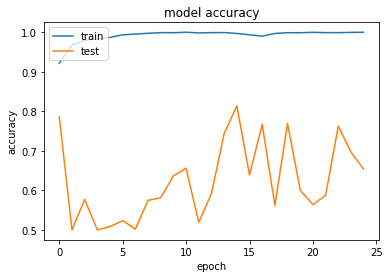

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.savefig('train_vs_test_accuracy_shuffled.png')
plt.show()


In [ ]:
## What does the above graph tell us about the model 
## -> What we see is that when it comes to training the model, it has high accuracy on the training set.
# However when looking at the testing accuracy we can see the accuracy after every epoch is quite volatile. 
# What this tell us is that the model has clearly not been able to learn from training data. When looking at the graph it also shows overfitting 
## But this comes secondary to the concept of the model actually underfitting even though the the accuracy on the training data is high. 

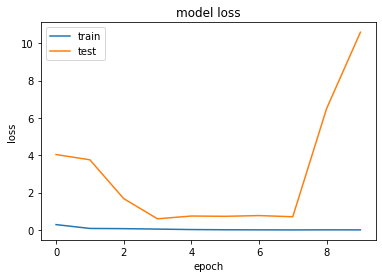

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_vs_test_loss_shuffled.png')
plt.show()

In [35]:
score = model.evaluate(X_test, y_test_ohe)
print('Loss ' , score[0])
print('Test accuracy: ', score[1]*100)

468/468 [==============================] - 0s 948us/step
Loss  10.586837837074555
Test accuracy:  52.99145579338074


In [25]:
y_pred = model.predict_classes(X_test)
y_pred[234:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Lets Visualise the output of Confusion Matrix

In [26]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.metrics import confusion_matrix

matrix = ["TN","FP"],["FN","TP"]
print(matrix[0])
print(matrix[1])

##Lets Visualise the output
conf=confusion_matrix(Y_test, y_pred)
print("Confusion Matrix")
print(conf)
# or we can use a heatmap from the seaborn library
#import seaborn as sn
#df_cm = pandas.DataFrame(conf, range(2), range(2))
#sn.set(font_scale=1.4)#for label size
#sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[  1 233]
 [  0 234]]
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       234
         1.0       0.50      1.00      0.67       234

    accuracy                           0.50       468
   macro avg       0.75      0.50      0.34       468
weighted avg       0.75      0.50      0.34       468

